# MLP for new type of datasets

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn

import pandas as pd
import numpy as np

# from tqdm import tqdm

import plotly.express as px
from torch.optim import Adam


import matplotlib.pyplot as plt

## Classes

In [21]:
class SequentDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, n_dots=1, n_dot_parameters=4):
        self.n_dot_parameters = n_dot_parameters
        self.n_dots = n_dots
        all_data = self.__make_stack(dataframe)
        self.X_ = all_data[:, :-n_dot_parameters]
        self.y_ = all_data[:, -n_dot_parameters:]

    def __len__(self):
        return len(self.X_)

    def __getitem__(self, idx):
        return self.X_[idx], self.y_[idx]

    def __make_stack(self, df: pd.DataFrame):
        stacks = [df.iloc[:-self.n_dots]] + [df.iloc[i:].values if (self.n_dots == i) else df.iloc[i:-(self.n_dots - i)].values for i in range(1, self.n_dots + 1)]
        return torch.tensor(np.hstack(stacks), dtype=torch.float32)

    def plotData(self, i = 0, f = -1):
        fig = px.line_3d(x = self.X_[i:f, 1], y = self.X_[i:f, 2], z = self.X_[i:f, 3])
        fig.show()

In [22]:
class MLPModel(nn.Module):
    def __init__(self, input_dots_amount, input_dot_parameters_amount, output_dots_amount, output_dot_parameters_amount, hidden_layers_lengths, dropout_probability=0, activation=nn.ReLU()):
        super(MLPModel, self).__init__()
        self.layers = nn.ModuleList()
        layer_lengths = [input_dots_amount * input_dot_parameters_amount] + hidden_layers_lengths + [output_dots_amount * output_dot_parameters_amount]
        #self.dropout = nn.Dropout(dropout_probability)
        self.activation = activation
        for i in range(1, len(layer_lengths)):
            self.layers.append(nn.Linear(layer_lengths[i - 1], layer_lengths[i]))


    def forward(self, X: torch.Tensor):
        X = X.clone()
        for layer in self.layers[:-1]:
            X = layer(X)
            X = self.activation(X)
            #X = self.dropout(X)
        return self.layers[-1](X)

## Палочки

In [23]:
N_DOTS = 25

In [24]:
dash_par_train = pd.read_csv("../../sets_for_article//parab_train.csv")
dash_par_test = pd.read_csv("../../sets_for_article//parab_test.csv")

dash_par_train['t'] = 1
dash_par_test['t'] = 1

In [25]:
dash_par_train

,t,X,Y,Z,I
0,1,38.500765,60.412528,38.581477,0
1,1,38.475476,60.408785,38.597572,0
2,1,38.443539,60.404604,38.617662,0
3,1,38.416618,60.399664,38.635212,0
4,1,38.383722,60.396531,38.655397,0
...,...,...,...,...,...
9995,1,-97.544418,55.902395,177.291541,0
9996,1,-97.542508,55.906543,177.301294,0
9997,1,-97.540409,55.909729,177.310947,0
9998,1,-97.538622,55.912594,177.319272,0


In [26]:
fig = px.line_3d(dash_par_train, x="X", y="Y", z="Z", color='I')
# fig = px.scatter_3d(data, x="X", y="Y", z="Z")
fig.show()

In [27]:
train = SequentDataset(dash_par_train[['t','X','Y','Z']][:8000], N_DOTS, 4)
test = SequentDataset(dash_par_train[['t','X','Y','Z']][8000:], N_DOTS, 4)
test2 = SequentDataset(dash_par_test[['t','X','Y','Z']], N_DOTS, 4)

In [28]:
model = MLPModel(input_dots_amount=N_DOTS, input_dot_parameters_amount=4, output_dots_amount=1, output_dot_parameters_amount=4, hidden_layers_lengths=[80, 40, 20])
# loss_model = nn.L1Loss()
loss_model = nn.HuberLoss()
# loss_model = nn.MSELoss()
opt = Adam(model.parameters(), lr=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)

In [29]:
# model.load_state_dict(torch.load("mlp_dash_31_10.pt"))

In [30]:
def train_model(model, criterion, optimizer, train_loader, device):
    model.train()
    train_loss = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
    
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()
    
    return sum(train_loss)/len(train_loss)

In [31]:
def evaluate_model(model, criterion, test_loader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss.append(loss.item())
    return sum(val_loss)/len(val_loss)

In [39]:
EPOCH = 30
train_losses = []
val_losses = []

train_data, val_data = random_split(train,[0.8,0.2])

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

for epoch in range(EPOCH):

    mean_train_loss = train_model(model, loss_model, opt, train_loader, "cpu")

    train_losses.append(mean_train_loss)

    mean_val_loss = evaluate_model(model, loss_model, val_loader, "cpu")

    val_losses.append(mean_val_loss)

    lr_scheduler.step()
    lr = lr_scheduler.get_last_lr()

    print(f"Epoch [{epoch+1}/{EPOCH}], train_loss = {mean_train_loss:.6f}, val_loss = {mean_val_loss:.6f}, lr = {lr}")

Epoch [1/30], train_loss = 0.000791, val_loss = 0.000726, lr = [7.8125e-06]
Epoch [2/30], train_loss = 0.000786, val_loss = 0.000679, lr = [7.8125e-06]
Epoch [3/30], train_loss = 0.000778, val_loss = 0.000829, lr = [7.8125e-06]
Epoch [4/30], train_loss = 0.000813, val_loss = 0.000670, lr = [7.8125e-06]
Epoch [5/30], train_loss = 0.000801, val_loss = 0.000800, lr = [3.90625e-06]
Epoch [6/30], train_loss = 0.000719, val_loss = 0.000742, lr = [3.90625e-06]
Epoch [7/30], train_loss = 0.000720, val_loss = 0.000688, lr = [3.90625e-06]
Epoch [8/30], train_loss = 0.000717, val_loss = 0.000656, lr = [3.90625e-06]
Epoch [9/30], train_loss = 0.000708, val_loss = 0.000706, lr = [3.90625e-06]
Epoch [10/30], train_loss = 0.000710, val_loss = 0.000729, lr = [1.953125e-06]
Epoch [11/30], train_loss = 0.000674, val_loss = 0.000702, lr = [1.953125e-06]
Epoch [12/30], train_loss = 0.000676, val_loss = 0.000655, lr = [1.953125e-06]
Epoch [13/30], train_loss = 0.000673, val_loss = 0.000680, lr = [1.953125e

<function matplotlib.pyplot.show(close=None, block=None)>

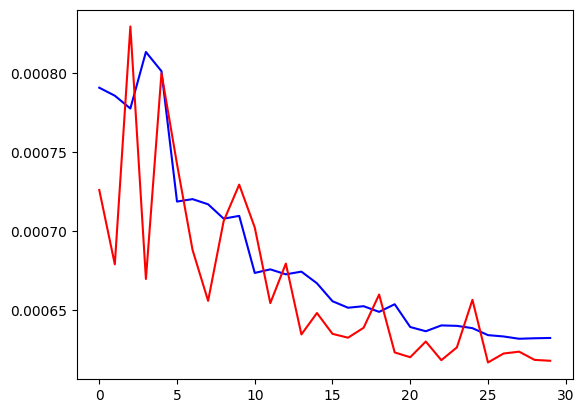

In [40]:
plt.plot(train_losses, '-b')
plt.plot(val_losses, '-r')
plt.show

In [34]:
# torch.save(model.state_dict(),"mlp_parab_31_10.pt")

In [41]:
predictions = []
true = []

start, _ = test[0]

for i in range(1000):
    with torch.no_grad():
        pred = model(start)
        predictions.append(pred[-4:])
        start = torch.hstack([start[4:], pred[-4:]])
        # start = pred
_, y_true  = test[:1000]
_, last = train[:]

In [42]:
pred_data = pd.DataFrame([[0,0,0,0,0]], columns=["Time", "X", "Y", "Z", "C"])

p_x = pd.DataFrame(map(lambda t: t.detach().tolist(), predictions), columns=["Time", "X", "Y", "Z"])
p_y = pd.DataFrame(y_true.detach().numpy(), columns=["Time", "X", "Y", "Z"])
p_last = pd.DataFrame(last.detach().numpy(), columns=["Time", "X", "Y", "Z"])
p_x["C"] = "Predict"
p_y["C"] = "True"
p_last["C"] = "Last"
pred_data = pd.concat([pred_data,p_x,p_y,p_last],axis=0)

In [43]:
aaaab = pred_data.drop(pred_data.index[0], inplace=False)

In [45]:
fig = px.line_3d(aaaab, x="X", y="Y", z="Z", color='C', markers=0)
fig.show()